# **Predicting Unemployment During Covid**
## Tim Hintz, Dan Valenzuela

***




## **Overview** <a id="Overview"></a>

In late 2019, the world was hit by the Sars-Covid-2. To prevent the spread of the disease, US state governments locked down the economy in March 2020. As a result of the pandemic, millions of people lost their jobs. The current research seeks to identify early signs that US households may lose their employment and in turn aid in the allocation of resources before the need is dire.


[**1. Business Problem**](#Business-Problem)

[**2. Data Understanding**](#Data-Understanding)

[**3. Data Preparation**](#Data-Preparation)

[**4. Data Analysis**](#Data-Analysis)

[**5. Evaluation**](#Evaluation)

[**6. Conclusion and Next Steps**](#Conclusion)
***

## **Business Problem** <a id="Business-Problem"></a>
[*↑ Back to overview*](#Overview)

Being able to predict which families and individuals are going to be in most dire need of financial assistence three months in advance will aid in providing the government with the necessary information for the distribution of relief funds. 

[*↑ Back to overview*](#Overview)
***

## **Data Understanding** <a id="Data-Understanding"></a>
[*↑ Back to overview*](#Overview)

### Current Population Survey

The data used in this model comes from the [Current Population Survey](https://www.census.gov/programs-surveys/cps/data/datasets.html) conducted by the U.S. Census Bureau. Each month the Census conducts a survey of 60,000 households and collects data on labor activity done in the past month. For the purposes of this project, we focused on households interviewed in April and July of 2020 which is the approximate range of dates that encapsulates the effects of coronavirus measures in the country, such as limited social activities. Further, although the dataset includes data about each individual in each household, we decided to keep adult individuals who were heads of household in April and July and were employed in April. Below is the resulting dataset using this filtering.

In [1]:
%load_ext autoreload
%autoreload 2

# Remove pink warning messages
from warnings import filterwarnings
filterwarnings('ignore')

# Graphing libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Required Packages to Graph a Decision Tree
from io import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


# Utility functions
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join( 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from modules import dataloading as dl
from modules import VizFig as vf
from modules import VizAx as va

images_dir = 'src/images/'
data_targetdir = 'src/data/'
csv_targetdir = 'src/csv/'

In [2]:
df = pd.read_csv('src/csv/employed_adults_apr2020_jul2020.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 9 to 72340
Columns: 777 entries, HRHHID_x to IND_ID_FINAL_y
dtypes: int64(774), object(3)
memory usage: 23.6+ MB


In [4]:
df.head()

,HRHHID_x,HRMONTH_x,HRYEAR4_x,HURESPLI_x,HUFINAL_x,HETENURE_x,HEHOUSUT_x,HETELHHD_x,HETELAVL_x,HEPHONEO_x,...,PTNMEMP1_y,PEPDEMP2_y,PTNMEMP2_y,PECERT1_y,PECERT2_y,PECERT3_y,PXCERT1_y,PXCERT2_y,PXCERT3_y,IND_ID_FINAL_y
9,6006205110907,4,2020,1,201,-1,1,1,-1,1,...,-1,-1,-1,2,-1,-1,20,0,0,600620511090711011402311
18,7380717096190,4,2020,1,201,-1,1,2,2,0,...,-1,-1,-1,1,1,2,20,20,20,738071709619010111401531
33,33081904003391,4,2020,1,201,-1,1,1,-1,1,...,-1,-1,-1,2,-1,-1,20,0,0,3308190400339110011401531
46,60021870004061,4,2020,1,201,-1,1,1,-1,1,...,-1,-1,-1,2,-1,-1,20,0,0,6002187000406110111402351
62,89031522004171,4,2020,1,201,-1,1,1,-1,1,...,-1,-1,-1,1,1,2,20,20,0,8903152200417111011401411


With respect to our business question, the target variable of interest is `PREMPNOT` which takes on values in the range of 1 through 4, each representing whether a person is employed, unemployed, and not in the labor force for one of two reasons. Because we structured this data to include only those who are employed in April, looking at `PREMPNOT` for data from that month would only show that all rows take the value of 1 meaning they were all employed. As for July, below is the distribution of employment status among the population we selected, where "NILF" means "not in labor force".

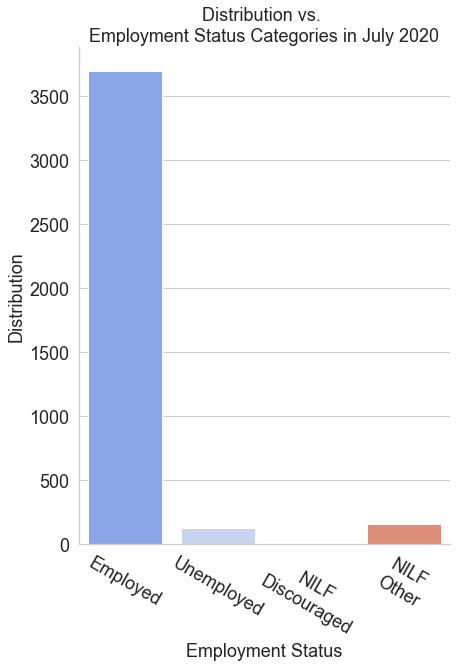

In [5]:
vf.PlotCat(df, xvar='PREMPNOT_y', targetdir=images_dir)

Further, as you can see above, there are over 300 features that are in each month's dataset recording a variety of demographic and labor data for each individual. For example, one can see in the graph below the number of males versus females in the dataset above. As one might expect, there is relative balance of males v. females in the population of employed heads of household with men outnumbering women slightly. Further, the distribution of age among this population is widespread with less frequency of young and older heads of household.

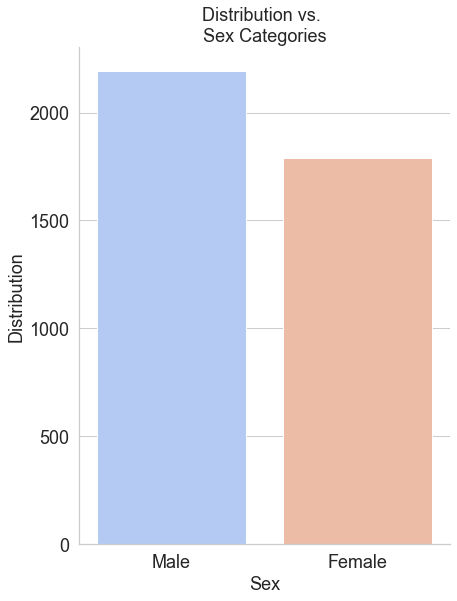

In [6]:
vf.PlotCat(df, 'PESEX_x', targetdir=images_dir)

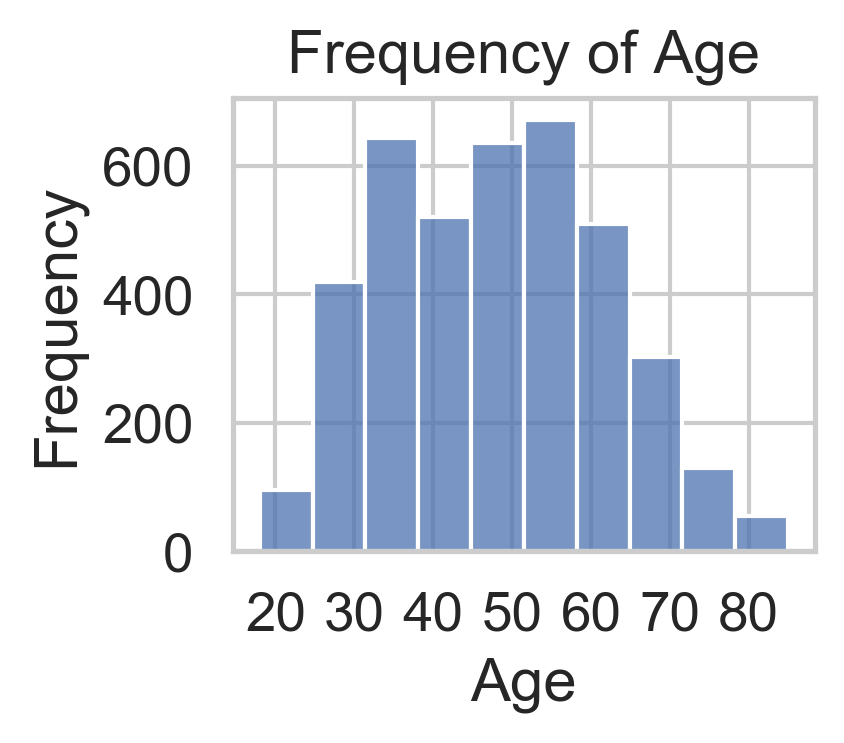

In [7]:
va.PlotHist(df, 'PRTAGE_x', targetdir=images_dir, bins=10)

For the sake of brevity, below is a list of all the features that were used in this dataset.

| Variable in CPS | Description| 
| --- | --- |
| HEHOUSUT | Type of housing | 
| GESTFIPS | State FIPS code |
| HEFAMINC | Family income |
| HRNUMHOU | Number of people in household |
| PRTAGE | Age of person |
| PEMARITL | Marital Status |
| PESEX | Sex of person |
| PEEDUCA | Level of education |
| PTDTRACE | Race composition of household |
| PEHSPNON | Hispanic status |
| PENATVTY | Born in US |
| PRCITSHP | Citizenship status |
| PRINUSYR | Immigrant's year of entry |
| PRHRUSL | Usual hours worked weekly |
| HUBUS | Ownership of business or farm in household |
| PEMJOT | More than 1 job or not |
| PEMJNUM | Num. of jobs if greater than 1|
| PEHRFTPT | Working more than 35 hours or not |
| PEHRRSN2 | Reasons for not working full-time |
| PEHRACTT | Number of hours worked in all jobs |
| PRAGNA | Works in agricultural industry? |
| PRNMCHILD | Number of children |
| PECYC | Number of college credit hours |
| PECERT1 | Professional certifi


### Political and Coronavirus Data

Political data came from a [kaggle](https://www.kaggle.com/unanimad/us-election-2020?select=president_county_candidate.csv) dataset that was scraped from the NYT API and was from the 2020 presidential election. We created a 'percent red' as a measure of how many Republicans are currently living in a given state. To supplement that information we scraped from wikipedia all the current Governers as an additional metric for political leaning.

Further, we collected data on covid prevalance from the [New York Times](https://github.com/nytimes/covid-19-data).

All this data was cleaned and merged using the the state fip code.

Cartographic data was sourced from [Census Bureau Cartographic Data](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)

Population data was sourced from [Census Bureau Population Data](https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html#par_textimage)

In [8]:
# import graphing data df
df_graphing = pd.read_csv('./src/csv/final_dataframe_graphing.csv')
# import shape files
df_shape = gpd.read_file('./src/csv/shapefiles/cb_2018_us_state_500k.shp')

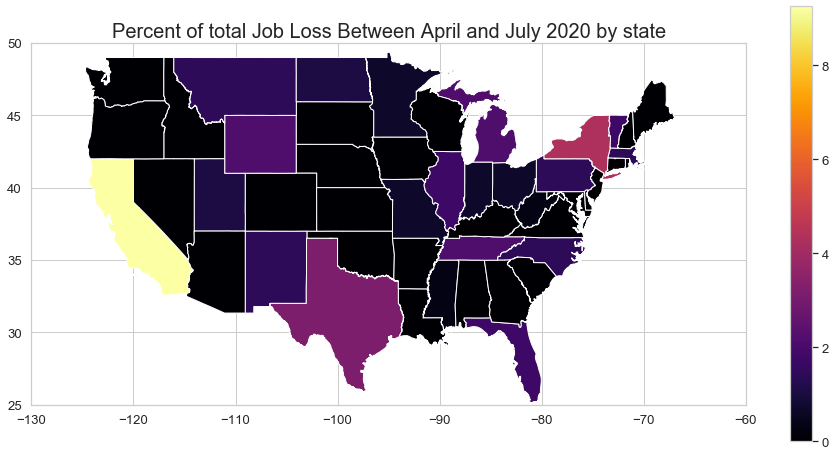

In [9]:
# plot state unemployement levels
df_shape.STATEFP = df_shape.STATEFP.astype(int)
target_sum_state = df_graphing.groupby(["GESTFIPS"]).target.sum().reset_index()

us_shape_target = df_shape.merge(target_sum_state, left_on='STATEFP', right_on='GESTFIPS', how='inner')
us_shape_target.target = (us_shape_target.target/us_shape_target.target.sum() * 100)

# Normalize data to the mean job loss of the nation.
us_shape_target.target = us_shape_target.target - us_shape_target.target.median()
us_shape_target.target = [x if x > 0 else 0 for x in us_shape_target.target]


fig, ax = plt.subplots(figsize = (16,8))
us_shape_target.plot(ax=ax,
                         alpha = 1,
                         column='target',
                         cmap = 'inferno',
                         legend=True)
ax.set_ylim(25,50)
ax.set_xlim(-130,-60)
ax.set_title("Percent of total Job Loss Between April and July 2020 by state", size=20);

From the above chloropleth, we notice that Texas, New York, Florida and California were hit hardest by unemployement between April and July. One reason that we hypothesised was the change in covid load between those two dates. Those states that had the highest increase in covid load would were locked down earliest.

We then visualised the increase in covid case load per state between April and July to visually inspect our hypothesis.

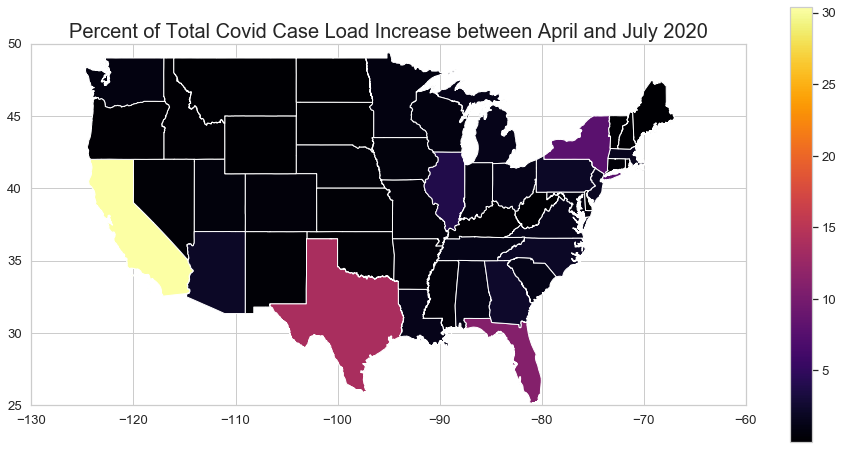

In [10]:
# plot state unemployment levels 
target_sum_delta = df_graphing.groupby(["GESTFIPS"]).case_delta.sum().reset_index()
us_shape_delta = df_shape.merge(target_sum_delta, left_on='STATEFP', right_on='GESTFIPS', how='inner')
us_shape_delta.case_delta = us_shape_delta.case_delta/us_shape_delta.case_delta.sum() * 100

fig, ax = plt.subplots(figsize = (16,8))
us_shape_delta.plot(ax=ax,
                         alpha = 1,
                         column='case_delta',
                         cmap = 'inferno',
                         legend=True)

ax.set_ylim(25,50)
ax.set_xlim(-130,-60)
    
ax.set_title("Percent of Total Covid Case Load Increase between April and July 2020", size=20);

The increase in Covid case load was highly correlated with population, the states hit hardest by covid were also those with the largest populations which we foud reasonable. There more people who live in an area, even if the rate of infection was consistent, a larger population would have higher case loads.

[*↑ Back to overview*](#Overview)
***

## **Data Preparation** <a id="Data-Preparation"></a>
[*↑ Back to overview*](#Overview)

### Current Population Survey

To prepare the data a few additional columns need to be generated in order to uniquely identify households and individuals. Households are uniquely identified by a concatenation of `HRHHID` and `HRHHID2` into `HH_ID`. Individuals, on the other hand, require a number of variables including `HH_ID`, age, and sex. The `clean_CPS_df` function below generates a unique identifier for individuals called `IND_ID_FINAL`.

In [11]:
# # Un-comment to run

# apr_2020_df = dl.CPS_raw(targetdir, ['apr2020'], None)
# jul_2020_df = dl.CPS_raw(targetdir, ['jul2020'], None)

# apr_2020_df = c.clean_CPS_df(apr_2020_df)
# jul_2020_df = c.clean_CPS_df(jul_2020_df)

With both of these dataframes in hand, they need to be merged. We merged datasets from each month based on the `HH_ID` identifier as we want to be able to track individuals across April and July datasets.

In [12]:
# # Un-comment to run
# merged = pd.merge(apr_2020_df, jul_2020, on=['HH_ID'], how='inner')

However, because this merge will still yield multiple individuals per household, the merged dataset is filtered down to adult heads of household who were employed in April. 

In [13]:
# # Un-comment to run
# adult_emp = merged[(merged.PERRP_x.isin([40,41])) 
#                        & (merged.PRPERTYP_x == 2) 
#                        & (merged.PERRP_y.isin([40,41])) 
#                        & (merged.PREMPNOT_x.isin([1]))]

Further, because the merge may still keep duplicates, we dropped all duplicates of `HH_ID`. Since we filtered down to only adult heads of household, this will yield one individual per household.

In [14]:
# # Un-comment to run
#  adult_emp = adult_emp.drop_duplicates(subset='HH_ID', keep='first')

Once all the above is run, you will return a dataframe that is equivalent to the dataframe imported from the CSV file above. Thus the dataframe `adult_emp` is equal to `df`. And you'll see that for every household there is one head of household. 

In [15]:
print(df.HH_ID.count())
print(df.IND_ID_FINAL_x.count())

3983
3983


Before this data can be used for analysis, each of the features above had to be binned or created into dummy variables in order to create an interpretable model.

With this dataset, this can finally be merged with political and coronavirus data according to the state that each individual belongs to. Further, this dataset is edited to ensure that only the target variable data from July is included and all the features are from April data.

In [16]:
df = pd.read_csv('src/csv/final_dataframe.csv')
df.head()

,HEHOUSUT,HWHHWGT,GESTFIPS,GTMETSTA,HEFAMINC,HRNUMHOU,HRHTYPE,PRTAGE,PEMARITL,PENATVTY,...,PEEDUCA_45,PEEDUCA_46,PTDTRACE_1,PTDTRACE_3,PEHSPNON_2,population,case_delta,party,percent_red,pop_density
0,1,40182430,1,1,16,3,1,31,1,1,...,0,0,0,0,1,4903185.0,57709.606452,1.0,62.087493,95.0
1,1,26376142,1,1,15,3,1,53,1,1,...,0,0,0,0,1,4903185.0,57709.606452,1.0,62.087493,95.0
2,1,37961372,1,1,13,3,1,53,1,1,...,0,0,0,0,1,4903185.0,57709.606452,1.0,62.087493,95.0
3,1,38997054,1,1,15,4,1,35,1,1,...,0,0,0,0,1,4903185.0,57709.606452,1.0,62.087493,95.0
4,1,42003612,1,1,11,8,3,40,0,1,...,0,0,1,0,1,4903185.0,57709.606452,1.0,62.087493,95.0


[*↑ Back to overview*](#Overview)
***

## **Data Analysis** <a id="Data-Analysis"></a>
[*↑ Back to overview*](#Overview)

As our business question is in regards to evaluating risk factors associated with an individual losing their job, we saught to fit a highly interpretable model. 

We fit two models. A decision tree classifier and a logistic regression classifier. We decided to use the logistic regression for two important reasons:
- It indirectly provides the probability of a feature in determining the outcome of the target variable
- It provides both a magnitude and a direction. We are not only concerned with which features are most important but in the context of our business question, we need to know which features will increase the chance of a person losing their job.
    - ie A decision tree won't tell you whether a feature is important for someone to keep their job or lose it. 

Further consideration is that the data set is highly imbalanced at close to 14:1. Therefore, we chose to use `class_weight = 'balanced'` in all instances of fitting. 

### Fit a Decision Tree Classifier

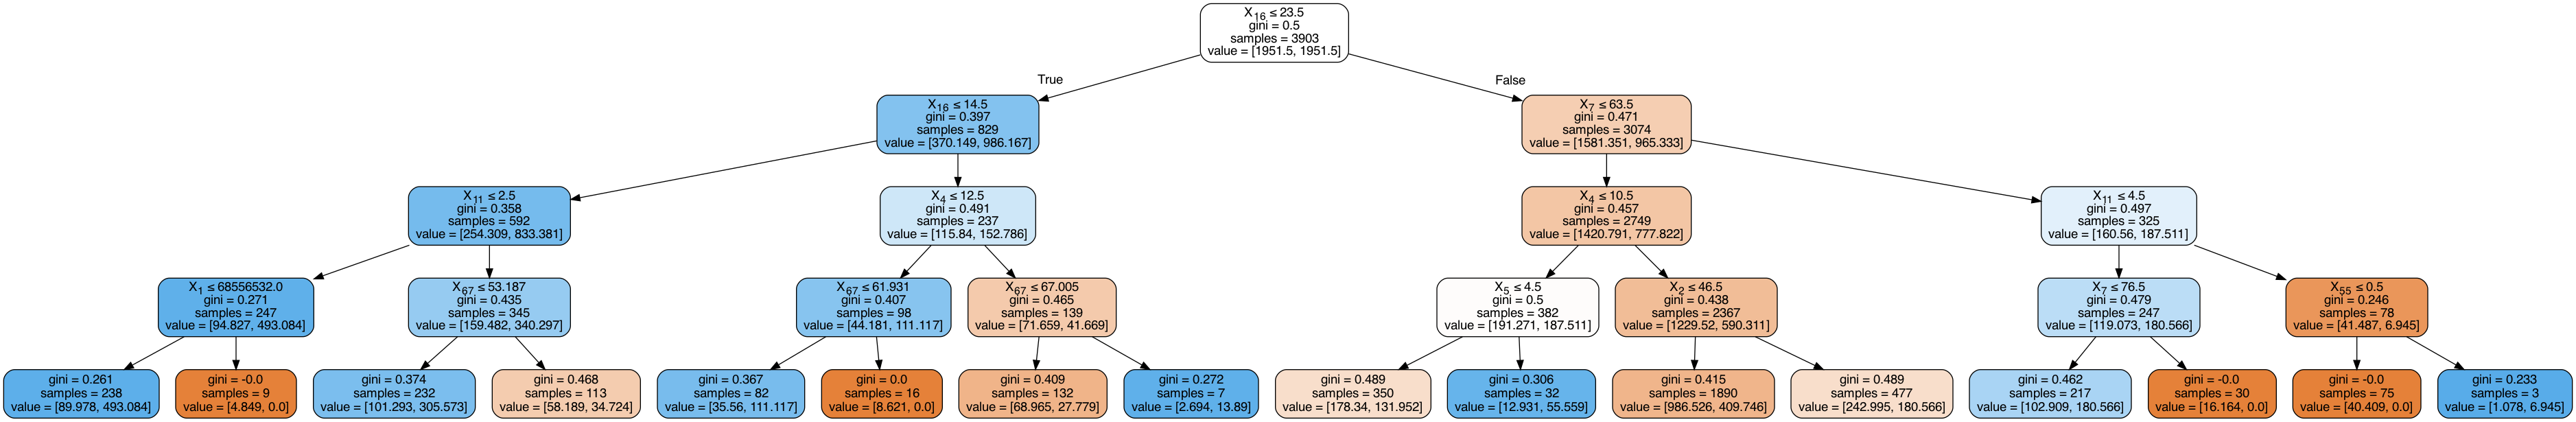

In [17]:
# Fit the decision tree classifier and graph the results
X = df.drop(columns = ['target'])
y = df.target
tree_clf = DecisionTreeClassifier(max_depth = 4, class_weight='balanced')
tree_clf.fit(X,y)

dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [18]:
sorted(zip(X.columns.to_list(), list(tree_clf.feature_importances_)), key = lambda x: x[1], reverse = True)[:7]

[('PEHRACTT', 0.5586115905413095),
 ('percent_red', 0.09534650146734924),
 ('HEFAMINC', 0.08243134674087245),
 ('PRTAGE', 0.07964840010629914),
 ('PRHRUSL', 0.07499869627835276),
 ('HRNUMHOU', 0.04038614690326645),
 ('GESTFIPS', 0.02771617746360545)]

The most important features were `PEHRACTT` which is the combined working hours of the houses reference person followed by `percent_red` which was how their state voted in the 2020 election. Then their `HEFAMINC` which was total family income. However, we do not know in which direction these features influence our data. 

Instead, let's use a Logistic regression model to get both a magnitude and a direction of the features. 

### Fit a Logisitc Regression Classifier

I will start by using a train test split on the data. However, we will make inferences on the final model.

In [19]:
# Train test split
X = df.drop(columns = ['target'])
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
logReg = LogisticRegression(class_weight = 'balanced')
logReg.fit(X_train, y_train)
y_hat_baseline = logReg.predict(X_test)
print(classification_report(y_test, y_hat_baseline))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82       890
           1       0.17      0.60      0.27        86

   micro avg       0.71      0.71      0.71       976
   macro avg       0.56      0.66      0.55       976
weighted avg       0.88      0.71      0.77       976



#### Our baseline logistic regression model has an recall/sensitivity of 0.6.

Since under estimating the number of people who may be in need of help is more damaging than over estimation, we tried to maximise recall.

To acheive this, we scaled our model using a Standardscalar and grid searched on both L1 and L2 regularization and settled on the following paramaters:

In [21]:
# Scale the X variables
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

In [22]:
logReg_grid_searched = LogisticRegression(class_weight='balanced',
                                          solver='saga',
                                          penalty='l1',
                                          C=0.02,
                                          random_state=42)
logReg_grid_searched.fit(X_train_scaled, y_train)
y_hat_grid = logReg_grid_searched.predict(X_test_scaled)
print(classification_report(y_test, y_hat_grid))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84       890
           1       0.20      0.67      0.31        86

   micro avg       0.74      0.74      0.74       976
   macro avg       0.58      0.71      0.57       976
weighted avg       0.89      0.74      0.79       976



Using the above model, we were able to increase our recall by 5 and our precision by 3. Since this is now the best model that we have we that is also interpretable, we can fit the model to the entire data set and interpret the results

In [23]:
# split into X and y
X = df.drop(columns=['target'])
y = df.target

# Scale the data
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

# Instantiate final logReg model
logReg_final = LogisticRegression(class_weight='balanced',
                                          solver='saga',
                                          penalty='l1',
                                          C=0.02,
                                          random_state=42)
logReg_final.fit(X_scaled, y)
y_hat_final = logReg_final.predict(X_scaled)
print(classification_report(y, y_hat_final))

              precision    recall  f1-score   support

           0       0.96      0.74      0.83      3622
           1       0.16      0.64      0.25       281

   micro avg       0.73      0.73      0.73      3903
   macro avg       0.56      0.69      0.54      3903
weighted avg       0.91      0.73      0.79      3903



### Confusion Matrix

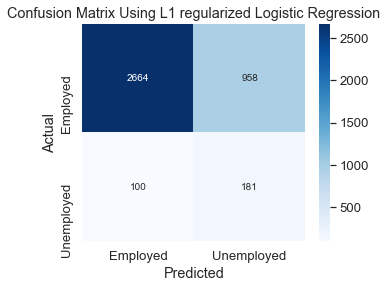

In [24]:
cmatrix = confusion_matrix(y, y_hat_final)
va.PlotCMatrix(cmatrix)

Using all of the data available to us, we found that we could only `positively identify 181` reference people as loosing their jobs over the course of the first wave of the pandemic. We had a lot of false postives, but once again, that is ok. We were able to `predict that 2/3` of the house holds that were going to loose their jobs. 

Knowing that this is as good as we are going to make our model, we are ready to interpret our most impactful coefficients.

In [25]:
# Save the most important coefficients for later analysis
coef_ = sorted(list(zip(X.columns.to_list(), logReg_final.coef_[0])), key = lambda x: x[1], reverse=True)
top_5_positive = coef_[:5]
top_5_negative = coef_[-5:]
top_10_features = top_5_positive + top_5_negative
top_10_df = pd.DataFrame(top_10_features, columns=['Features', 'LogRegCoeff'])

[*↑ Back to overview*](#Overview)
***

## **Evaluation**<a id="Evaluation"></a>
[*↑ Back to overview*](#Overview)

Now that we have the features that are the most influential on the whether or not someone would lose their job during a covid outbreak. 

Let's first look at the most influential in someon keeping their job and the most influential in loosing their job.

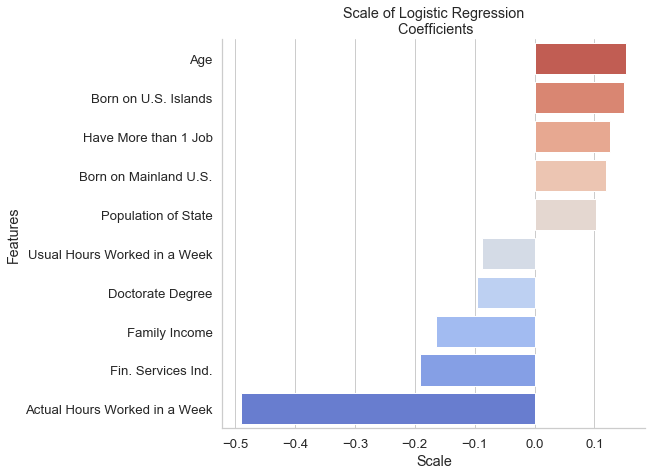

In [26]:
vf.PlotCatCoeff(top_10_df, yvar='Features',targetdir = images_dir, xvar='LogRegCoeff', orient='h',kind='bar')

We selected 5 features with negative signs and 5 features with positive signs for our interpretation.


By far the most influential feature in our final model was `Actual Hours Worked in a Week` which is the total amount of time people spend working between all of their jobs. However, some people in our data set have more than one job. The column `More than 1 Job` is a dummy column that refers to whether or not people have more than 1 job. Those people who do have more than one job were 10% more likely to loose their job than someone who only had one job. This lead us to believe that there is a missing piece of the story here. More data data on the demographics of people with two jobs should be found before we can make a definitive comment on it.

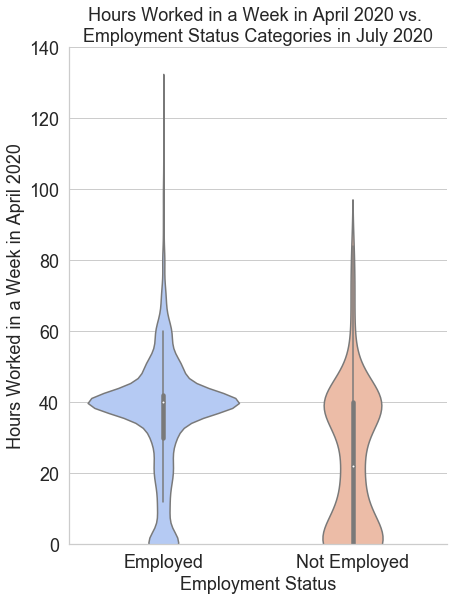

In [27]:
vf.PlotCat(df, xvar='target', yvar='PEHRACTT', kind='violin', targetdir=images_dir)



The reference person's age or `Age` was impactful. The older people were, the higher the chance of them leaving the work force. We wonder if you were able to normalize the job loss over this period to a baseline control would age be as impactful? That is to say, are older people just leaving the work force at a higher rate than other groups?



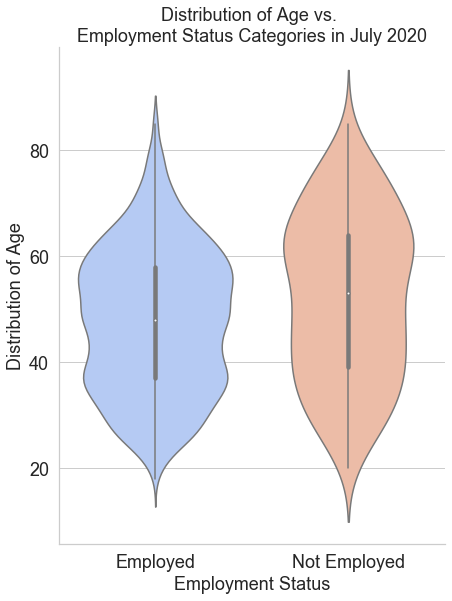

In [28]:
vf.PlotCat(df, xvar='target', yvar='PRTAGE', kind='violin', targetdir=images_dir)

`Population` was a feature that we struggled with. Of course, the higher the population, the larger the covid and unemployment and competition for jobs. We also included the population density into our model but that wasn't found to be impactful. One reason for this could be is that the most populated areas are not necessarily the most densley packed at the state level. Brooklyn and Manhatten are heavily populated but Syrucuse is not. We felt that more granular geographic data was required to draw inferences state by state.

Two other factors critical in staying employed were `Fin. Services. In` and `Family Income` which were people who worked in the financial industry and the total income of the house, respectively. We thought that there was going to be more of an inpact from industry and occupation but we were wrong in that hypothesis.

An initially unexpected result was `Born on US Mainland` which was whether or not the reference person was born in the US. People born in the US had a 10% higher chance of loosing their job compared to those born overseas. Two factors could account for this. First, people who are here from over seas may have come on specialist visa, meanthing their employment ws more secure than otherwise. Alternatively, the increase in likelyhood could be due to severe class imbalance between the groups.

In confirmation of the US born finding in `Born on US Island` referred to US citizens born in Puerto Rico were also 10% higher risk of loosing their jobs compared to those not born on US soil. This could indicate that specific minority groups were hit hardest by unemployment but more demographic data is needed to draw real inferences. Here, we indicate that people born on a US island are higher risk to loose their jobs.

Finally, we were underwhelmed by effect of education on job security. We hypothesised that peoples education would have an impact on probability of loosing their job. However, only one of the education categories (`Doctorate Degree`) made it in as a final feature. In addition, the ordinal categorical variable `PECYC` which was the number of years spent in college didn't make it it into the model at all as it was removed by the lasso regularization.[*↑ Back to overview*](#Overview)
***

## **Conclusion and Next Steps**<a id="Conclusion"></a>
[*↑ Back to overview*](#Overview)

The Features Age, Industry, Birth Place and Income are all important factors in determining whether someone is high risk for losing their job in the current climate. 

Further research could be done to establish a baseline control to assess if the current time of April to July 2020 was indeed greater than normal. Further more, historical data on past financial crisis could be evaluated to look for consistent feature and create a more accurate early warning sign for government assistence. Finally, collect granular data. We believe that people prone to job loss is more likely to be state specific than nation wide.

[*↑ Back to overview*](#Overview)
***